Mencoba memuat gambar: ../data\ISBI2016_ISIC_Part3B_Training_Data\ISIC_0000000.jpg
Mencoba memuat masker: ../data\ISBI2016_ISIC_Part3B_Training_Data\ISIC_0000000_segmentation.png


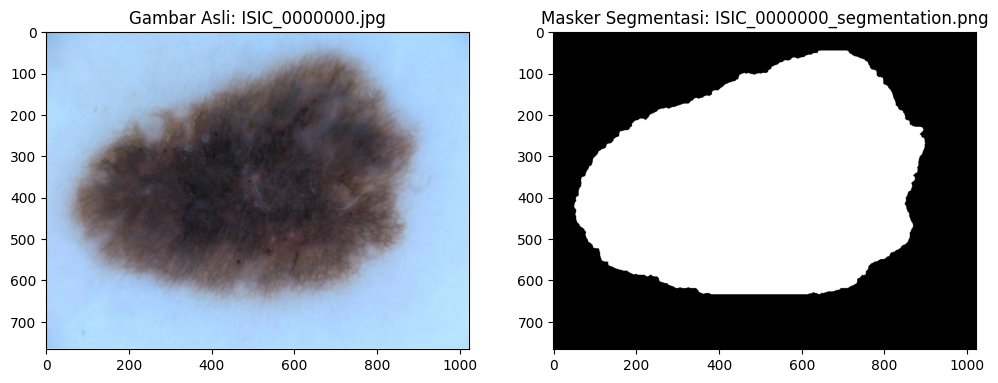

Dimensi Gambar: (767, 1022, 3)
Dimensi Masker: (767, 1022)
Nilai unik piksel di Masker: [  0 255]


In [2]:
# Import semua library dan persiapan dataset
import os
import cv2 # Untuk membaca dan memproses gambar
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

# --- Konfigurasi Jalur Data ---
base_data_path = '../data'

images_dir = os.path.join(base_data_path, 'ISBI2016_ISIC_Part3B_Training_Data')
masks_dir = os.path.join(base_data_path, 'ISBI2016_ISIC_Part3B_Training_Data')

In [ ]:
# Memuat dan Memvisualisasikan Satu Contoh Gambar dan Mask
image_files = sorted([f for f in os.listdir(images_dir) if f.endswith('.jpg')])

example_image_name = image_files[0]
example_image_path = os.path.join(images_dir, example_image_name)

example_mask_name = example_image_name.replace('.jpg', '_segmentation.png')
example_mask_path = os.path.join(masks_dir, example_mask_name)

print(f"Mencoba memuat gambar: {example_image_path}")
print(f"Mencoba memuat masker: {example_mask_path}")

# Membaca gambar dan masker menggunakan OpenCV
# cv2.imread membaca gambar sebagai BGR secara default, flags=cv2.IMREAD_COLOR
# untuk gambar warna, flags=cv2.IMREAD_GRAYSCALE untuk masker (hitam putih)
image = cv2.imread(example_image_path, cv2.IMREAD_COLOR)
mask = cv2.imread(example_mask_path, cv2.IMREAD_GRAYSCALE)

# Konversi gambar dari BGR ke RGB untuk tampilan matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title(f'Gambar Asli: {example_image_name}')
# plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title(f'Masker Segmentasi: {example_mask_name}')
# plt.axis('off')

plt.show()

print(f"Dimensi Gambar: {image.shape}")
print(f"Dimensi Masker: {mask.shape}")
print(f"Nilai unik piksel di Masker: {np.unique(mask)}")


Memproses 900 sampel gambar dan maskernya...
  Sudah memproses 10 gambar...
  Sudah memproses 20 gambar...
  Sudah memproses 30 gambar...
  Sudah memproses 40 gambar...
  Sudah memproses 50 gambar...
  Sudah memproses 60 gambar...
  Sudah memproses 70 gambar...
  Sudah memproses 80 gambar...
  Sudah memproses 90 gambar...
  Sudah memproses 100 gambar...
  Sudah memproses 110 gambar...
  Sudah memproses 120 gambar...
  Sudah memproses 130 gambar...
  Sudah memproses 140 gambar...
  Sudah memproses 150 gambar...
  Sudah memproses 160 gambar...
  Sudah memproses 170 gambar...
  Sudah memproses 180 gambar...
  Sudah memproses 190 gambar...
  Sudah memproses 200 gambar...
  Sudah memproses 210 gambar...
  Sudah memproses 220 gambar...
  Sudah memproses 230 gambar...
  Sudah memproses 240 gambar...
  Sudah memproses 250 gambar...
  Sudah memproses 260 gambar...
  Sudah memproses 270 gambar...
  Sudah memproses 280 gambar...
  Sudah memproses 290 gambar...
  Sudah memproses 300 gambar...
  S

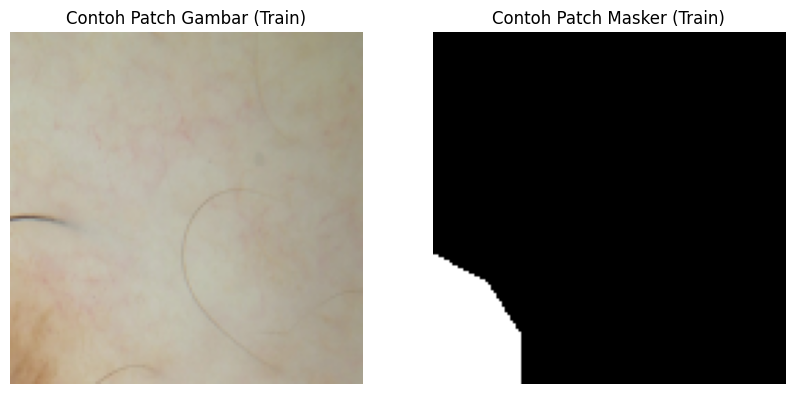

In [2]:
# PRE-PROCESSING

base_data_path = '../data'
images_dir = os.path.join(base_data_path, 'ISBI2016_ISIC_Part3B_Training_Data')
masks_dir = os.path.join(base_data_path, 'ISBI2016_ISIC_Part3B_Training_Data')

# --- Parameter Pra-pemrosesan ---
TARGET_IMAGE_SIZE = (256, 256)
PATCH_SIZE = (128, 128)
OVERLAP_RATIO = 0.0

# Fungsi untuk memuat dan pre-processing Gambar/Masker
def load_and_preprocess_image_mask(image_path, mask_path, target_size):
    # Membaca gambar dan masker
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Periksa apakah gambar berhasil dimuat
    if image is None:
        print(f"Error: Gagal memuat gambar dari {image_path}")
        return None, None
    if mask is None:
        print(f"Error: Gagal memuat masker dari {mask_path}")
        return None, None

    # Konversi BGR ke RGB untuk gambar
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)
    mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_AREA) # Masker juga di-resize

    # Normalisasi gambar ke rentang 0-1
    image = image / 255.0

    mask = mask / 255.0
    mask[mask > 0.5] = 1.0 # Pembulatan
    mask[mask <= 0.5] = 0.0
    mask = mask.astype(np.float32) # Tipe data float32 untuk TensorFlow

    # Tambahkan dimensi channel jika masker hanya 2D (HxW -> HxWx1)
    # Ini diperlukan untuk input/output U-Net yang mengharapkan HxWxChannels
    mask = np.expand_dims(mask, axis=-1)

    return image, mask

# [Tahap Divide] Fungsi untuk Membagi Gambar menjadi Patch 
def get_patches(image, mask, patch_size, overlap_ratio=0.0):
    patches_image = []
    patches_mask = []

    h, w, _ = image.shape
    patch_h, patch_w = patch_size

    stride_h = int(patch_h * (1 - overlap_ratio))
    stride_w = int(patch_w * (1 - overlap_ratio))

    if stride_h == 0: stride_h = 1 # Hindari stride 0 jika overlap 100%
    if stride_w == 0: stride_w = 1

    for y in range(0, h - patch_h + 1, stride_h):
        for x in range(0, w - patch_w + 1, stride_w):
            img_patch = image[y:y+patch_h, x:x+patch_w]
            mask_patch = mask[y:y+patch_h, x:x+patch_w]
            
            patches_image.append(img_patch)
            patches_mask.append(mask_patch)
            
    # Jika gambar terlalu kecil atau hanya satu patch, pastikan ada minimal satu patch
    if not patches_image and h >= patch_h and w >= patch_w:
        patches_image.append(image[0:patch_h, 0:patch_w])
        patches_mask.append(mask[0:patch_h, 0:patch_w])
    elif not patches_image: # Jika gambar lebih kecil dari patch size, resize ke patch size
        img_resized = cv2.resize(image, patch_size, interpolation=cv2.INTER_AREA) / 255.0
        mask_resized = cv2.resize(mask, patch_size, interpolation=cv2.INTER_AREA) / 255.0
        mask_resized = np.expand_dims(mask_resized, axis=-1)
        patches_image.append(img_resized)
        patches_mask.append(mask_resized)

    return np.array(patches_image), np.array(patches_mask)

# --- Mengumpulkan Semua Jalur Gambar dan Masker ---
all_image_paths = sorted([os.path.join(images_dir, f) for f in os.listdir(images_dir) if f.endswith('.jpg')])
all_mask_paths = sorted([os.path.join(masks_dir, f) for f in os.listdir(masks_dir) if f.endswith('.png')])

# Pastikan jumlah gambar dan masker sama
if len(all_image_paths) != len(all_mask_paths):
    print("WARNING: Jumlah gambar dan masker tidak sama! Mungkin ada masalah dengan data.")

X_patches = [] # Untuk menyimpan semua patch gambar
Y_patches = [] # Untuk menyimpan semua patch mask

NUM_SAMPLES_FOR_PROTOTYPE = 1279

print(f"\nMemproses {NUM_SAMPLES_FOR_PROTOTYPE} sampel gambar dan maskernya...")
for i in range(min(NUM_SAMPLES_FOR_PROTOTYPE, len(all_image_paths))):
    img_path = all_image_paths[i]
    mask_path = all_mask_paths[i]
    
    image, mask = load_and_preprocess_image_mask(img_path, mask_path, TARGET_IMAGE_SIZE)
    
    if image is not None and mask is not None:
        # Gambar di-divide di sini
        img_p, mask_p = get_patches(image, mask, PATCH_SIZE, OVERLAP_RATIO)
        X_patches.extend(img_p)
        Y_patches.extend(mask_p)
    
    if (i + 1) % 10 == 0:
        print(f"  Sudah memproses {i + 1} gambar...")

X_patches = np.array(X_patches, dtype=np.float32)
Y_patches = np.array(Y_patches, dtype=np.float32)

print(f"\nTotal patch gambar yang terkumpul: {X_patches.shape}")
print(f"Total patch masker yang terkumpul: {Y_patches.shape}")

# --- Membagi Data menjadi Set Pelatihan dan Validasi ---
# Kita akan membagi patch, bukan gambar utuh
X_train, X_val, Y_train, Y_val = train_test_split(X_patches, Y_patches, test_size=0.2, random_state=42)

print(f"\nJumlah patch untuk pelatihan (X_train): {X_train.shape}")
print(f"Jumlah patch untuk validasi (X_val): {X_val.shape}")
print(f"Jumlah patch untuk pelatihan (Y_train): {Y_train.shape}")
print(f"Jumlah patch untuk validasi (Y_val): {Y_val.shape}")

# --- Memvisualisasikan Contoh Patch ---
sample_idx = np.random.randint(0, len(X_train))
sample_image_patch = X_train[sample_idx]
sample_mask_patch = Y_train[sample_idx]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample_image_patch)
plt.title('Contoh Patch Gambar (Train)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(sample_mask_patch[:,:,0], cmap='gray') # Ambil channel pertama masker
plt.title('Contoh Patch Masker (Train)')
plt.axis('off')
plt.show()

In [3]:
# PERSIAPAN MODEL U-NET

IMG_HEIGHT, IMG_WIDTH = PATCH_SIZE # Input U-Net adalah ukuran patch
IMG_CHANNELS = 3 
NUM_CLASSES = 1 

# Dice Coefficient adalah metrik umum untuk segmentasi,
# mengukur tumpang tindih antara prediksi dan ground truth.
def dice_coef(y_true, y_pred, smooth=1e-7):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# --- Fungsi Loss Kustom: Dice Loss ---
def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

# --- Membangun Model U-Net ---
def build_unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    inputs = Input(input_shape)
    # Block 1
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    # Block 2
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    # Block 3
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    # Block 4
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    # Bottleneck (Lowest Point)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)
    # Decoder (Expanding Path)
    # Block 6 (Up-sampling dan Skip Connection dari conv4)
    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = Conv2D(512, (2, 2), activation='relu', padding='same')(up6) # Transposed conv bisa juga
    merge6 = concatenate([conv4, up6], axis=3) # Skip connection
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)
    # Block 7 (Up-sampling dan Skip Connection dari conv3)
    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = Conv2D(256, (2, 2), activation='relu', padding='same')(up7)
    merge7 = concatenate([conv3, up7], axis=3) # Skip connection
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)
    # Block 8 (Up-sampling dan Skip Connection dari conv2)
    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = Conv2D(128, (2, 2), activation='relu', padding='same')(up8)
    merge8 = concatenate([conv2, up8], axis=3) # Skip connection
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)
    # Block 9 (Up-sampling dan Skip Connection dari conv1)
    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9 = Conv2D(64, (2, 2), activation='relu', padding='same')(up9)
    merge9 = concatenate([conv1, up9], axis=3) # Skip connection
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)
    # Output Layer
    # Lapisan 1x1 konvolusi untuk memetakan jumlah fitur terakhir ke jumlah kelas
    output = Conv2D(NUM_CLASSES, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=output)
    
    # Compile model
    model.compile(optimizer=Adam(learning_rate=1e-4), 
                  loss='binary_crossentropy',
                  metrics=[dice_coef, 'accuracy'])
    return model

# --- Instansiasi dan Ringkasan Model ---
unet_model = build_unet()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 128, 128, 64)      │           1,792 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 128, 128, 64)      │          36,928 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 64, 64, 64)        │               0 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 64, 64, 128)       │          73,856 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 64, 64, 128)       │         147,584 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 32, 32, 128)       │               0 │ conv2d_3[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 32, 32, 256)       │         295,168 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 32, 32, 256)       │         590,080 │ conv2d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 16, 16, 256)       │               0 │ conv2d_5[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 16, 16, 512)       │       1,180,160 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 16, 16, 512)       │       2,359,808 │ conv2d_6[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_3               │ (None, 8, 8, 512)         │               0 │ conv2d_7[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_8 (Conv2D)             │ (None, 8, 8, 1024)        │       4,719,616 │ max_pooling2d_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_9 (Conv2D)             │ (None, 8, 8, 1024)        │       9,438,208 │ conv2d_8[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ up_sampling2d (UpSampling2D)  │ (None, 16, 16, 1024)      │               

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# PELATIHAN MODEL

# Parameter Pelatihan Model
BATCH_SIZE = 32  # Ukuran batch (jumlah patch yang diproses sekaligus)
EPOCHS = 20      # Jumlah epoch (berapa kali model melihat seluruh dataset pelatihan)

print(f"\nMemulai pelatihan model U-Net dengan {EPOCHS} epoch dan batch size {BATCH_SIZE}...")

history = unet_model.fit(X_train, Y_train,
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          validation_data=(X_val, Y_val),
                          verbose=1) # verbose=1 akan menampilkan progress bar

print("\nPelatihan model selesai.")

# Memvisualisasikan Log Pelatihan
# Plot loss pelatihan dan validasi
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss Pelatihan')
plt.plot(history.history['val_loss'], label='Loss Validasi')
plt.title('Grafik Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Dice Coefficient pelatihan dan validasi
plt.subplot(1, 2, 2)
plt.plot(history.history['dice_coef'], label='Dice Coef Pelatihan')
plt.plot(history.history['val_dice_coef'], label='Dice Coef Validasi')
plt.title('Grafik Dice Coefficient Model')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Memulai pelatihan model U-Net dengan 20 epoch dan batch size 32...
Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 951s 10s/step - accuracy: 0.7378 - dice_coef: 0.3305 - loss: 0.5673 - val_accuracy: 0.8371 - val_dice_coef: 0.5216 - val_loss: 0.4030
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 967s 11s/step - accuracy: 0.8284 - dice_coef: 0.4718 - loss: 0.4195 - val_accuracy: 0.8845 - val_dice_coef: 0.6250 - val_loss: 0.3090
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 940s 10s/step - accuracy: 0.8861 - dice_coef: 0.6580 - loss: 0.2967 - val_accuracy: 0.9095 - val_dice_coef: 0.7420 - val_loss: 0.2320
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 942s 10s/step - accuracy: 0.8997 - dice_coef: 0.7243 - loss: 0.2568 - val_accuracy: 0.9211 - val_dice_coef: 0.7686 - val_loss: 0.2001
Epoch 5/20
 8/90 ━━━━━━━━━━━━━━━━━━━━ 13:14 10s/step - accuracy: 0.9259 - dice_coef: 0.7646 - loss: 0.2014

In [ ]:
# Evaluasi kinerja model

import random # Untuk memilih contoh secara acak

# Evaluasi Kuantitatif Model pada Set Validasi
print("\nMelakukan evaluasi model pada set validasi...")
# unet_model.evaluate akan mengembalikan loss dan metrik yang Anda definisikan saat compile
loss, dice_coefficient, accuracy = unet_model.evaluate(X_val, Y_val, verbose=0)

print(f"Loss pada set validasi: {loss:.4f}")
print(f"Dice Coefficient pada set validasi: {dice_coefficient:.4f}")
print(f"Akurasi pada set validasi: {accuracy:.4f}")

# Prediksi pada Contoh Patch dari Set Validasi 
print("\nMembuat prediksi pada contoh patch dari set validasi...")
# Ambil beberapa contoh patch dari set validasi
num_sample_patches_to_show = 5
sample_indices = np.random.choice(len(X_val), num_sample_patches_to_show, replace=False)

plt.figure(figsize=(15, 10))
for i, idx in enumerate(sample_indices):
    sample_patch_image = X_val[idx]
    sample_patch_mask_true = Y_val[idx]
    
    # Model mengharapkan batch, jadi tambahkan dimensi batch
    sample_patch_image_input = np.expand_dims(sample_patch_image, axis=0)
    
    # Lakukan prediksi
    sample_patch_mask_pred = unet_model.predict(sample_patch_image_input)[0] # Ambil hasil pertama dari batch
    sample_patch_mask_pred_binary = (sample_patch_mask_pred > 0.5).astype(np.float32)

    plt.subplot(num_sample_patches_to_show, 3, i*3 + 1)
    plt.imshow(sample_patch_image)
    plt.title('Patch Asli')
    plt.axis('off')

    plt.subplot(num_sample_patches_to_show, 3, i*3 + 2)
    plt.imshow(sample_patch_mask_true[:,:,0], cmap='gray') # Ambil channel pertama masker
    plt.title('Masker Ground Truth')
    plt.axis('off')

    plt.subplot(num_sample_patches_to_show, 3, i*3 + 3)
    plt.imshow(sample_patch_mask_pred_binary[:,:,0], cmap='gray') # Ambil channel pertama masker prediksi
    plt.title('Masker Prediksi')
    plt.axis('off')

plt.suptitle('Contoh Prediksi Segmentasi pada Patch (Set Validasi)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

In [ ]:
# Demonstrasi Prediksi dan Rekonstruksi Gambar Utuh (Divide and Conquer)
print("\nMelakukan prediksi dan rekonstruksi pada satu gambar utuh...")

# Pilih satu gambar asli dari dataset awal (bukan dari X_val/X_train)
if len(all_image_paths) > NUM_SAMPLES_FOR_PROTOTYPE:
    full_image_idx = random.randint(NUM_SAMPLES_FOR_PROTOTYPE, len(all_image_paths) - 1)
else:
    full_image_idx = random.randint(0, len(all_image_paths) - 1)

full_original_image_path = all_image_paths[full_image_idx]
full_original_mask_path = all_mask_paths[full_image_idx]

# Load dan Preprocess gambar utuh ke TARGET_IMAGE_SIZE
full_image_resized, full_mask_resized = load_and_preprocess_image_mask(
    full_original_image_path, full_original_mask_path, TARGET_IMAGE_SIZE
)

if full_image_resized is not None and full_mask_resized is not None:
    start_time = time.time()

    # Divide
    patches_to_predict, _ = get_patches(full_image_resized, full_mask_resized, PATCH_SIZE, OVERLAP_RATIO)
    num_patches = len(patches_to_predict)

    # Conquer
    predicted_patches_raw = unet_model.predict(patches_to_predict, verbose=0)
    predicted_patches_binary = (predicted_patches_raw > 0.5).astype(np.float32)

    # Combine
    reconstructed_mask = np.zeros(full_image_resized.shape[:2] + (NUM_CLASSES,), dtype=np.float32)

    h_full, w_full, _ = full_image_resized.shape
    patch_h, patch_w = PATCH_SIZE

    idx_patch = 0
    stride_h = int(patch_h * (1 - OVERLAP_RATIO))
    stride_w = int(patch_w * (1 - OVERLAP_RATIO))
    if stride_h == 0: stride_h = 1
    if stride_w == 0: stride_w = 1

    for y in range(0, h_full - patch_h + 1, stride_h):
        for x in range(0, w_full - patch_w + 1, stride_w):
            if idx_patch < len(predicted_patches_binary):
                reconstructed_mask[y:y+patch_h, x:x+patch_w] = predicted_patches_binary[idx_patch]
                idx_patch += 1
            else:
                break
        if idx_patch >= len(predicted_patches_binary):
            break

    if idx_patch == 0 and len(predicted_patches_binary) == 1:
        reconstructed_mask = predicted_patches_binary[0]

    end_time = time.time()
    processing_time = end_time - start_time
    print(f"  Waktu yang dibutuhkan untuk proses Divide -> Conquer -> Combine (1 gambar): {processing_time:.4f} detik")

    # --- VISUALISASI PROCESS
    # 1. Tampilkan Gambar Utuh (Gambar 4.1a)
    plt.figure(figsize=(8, 8))
    plt.imshow(full_image_resized)
    plt.title(f'Gambar Asli Utuh (Resized ke {TARGET_IMAGE_SIZE})')
    plt.axis('off')
    plt.show()

    rows = int(np.ceil(np.sqrt(num_patches)))
    cols = int(np.ceil(num_patches / rows))

    plt.figure(figsize=(cols*3, rows*3))
    for i in range(num_patches):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(patches_to_predict[i])
        plt.title(f'Patch {i+1}')
        plt.axis('off')
    plt.suptitle('Gambar Utuh Dipecah Menjadi Patch', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # 3. Tampilkan Hasil Prediksi pada Masing-masing Patches (Gambar 4.1c)
    plt.figure(figsize=(cols*3, rows*3))
    for i in range(num_patches):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(predicted_patches_binary[i,:,:,0], cmap='gray')
        plt.title(f'Prediksi Patch {i+1}')
        plt.axis('off')
    plt.suptitle('Gambar Hasil Prediksi Segmentasi pada Setiap Patch', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # 4. Perbandingan Gambar Asli, Segmentasi Asli, Hasil Model (Gambar 3.4 / Gambar 4.1d)
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(full_image_resized)
    plt.title(f'Gambar Asli (Resized ke {TARGET_IMAGE_SIZE})')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(full_mask_resized[:,:,0], cmap='gray')
    plt.title('Masker Ground Truth (Resized)')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(reconstructed_mask[:,:,0], cmap='gray')
    plt.title('Masker Prediksi Rekonstruksi (Model Hybrid)')
    plt.axis('off')

    plt.suptitle('Gambar 4.1d. Segmentasi Gambar Utuh: Divide -> Conquer -> Combine', fontsize=16)
    plt.show()

else:
    print("Gagal memuat gambar utuh untuk demonstrasi rekonstruksi.")